## Background

__Twitter__ has become a wildly sprawling jungle of information&mdash;140 characters at a time. Somewhere between 350 million and 500 million tweets are estimated to be sent out _per day_. With such an explosion of data, on Twitter and elsewhere, it becomes more important than ever to tame it in some way, to concisely capture the essence of the data.

## News Mood

A python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: __BBC, CBS, CNN, Fox, and New York times__.



The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last __100__ tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

The tools of the trade you will need for your task as a data analyst include the following: tweepy, pandas, matplotlib, seaborn, textblob, and VADER.

Included analysis:

* Pull last 100 tweets from each outlet.
* Sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet. 
* A DataFrame the tweet's source acount, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* DataFrame into a CSV file.
* PNG images for each plot.

In [29]:
import tweepy
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [30]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [14]:
#list of the news outlet - on Tweeter 
targets=['BBC', 'CBS', 'CNN', 'FoxNews' , 'nytimes', 'washingtonpost']

In [16]:
#Initiating and empty table to hold data from twitter   
cols=['Tweets', 'Followers', 'Following', 'Favorites Count']
popular_news= pd.DataFrame(index=targets ,columns=cols).reset_index()
popular_news=popular_news.rename(columns = {'index':'Screen Name'})

In [27]:
# Iterate through DataFrame
for index, row in popular_news.iterrows():
    try:
        # Grab the username
        target_user = row["Screen Name"]
        # print(target_user)

        # Use the username with the Twitter API get_user
        user_account = api.get_user(target_user)
        user_real_name = user_account["name"]

        # Get the specific column data
        user_tweets = user_account["statuses_count"]
        user_followers = user_account["followers_count"]
        user_following = user_account["friends_count"]
        user_favorites = user_account["favourites_count"]

        # Replace the row information for each
        popular_news.set_value(index, "Real Name", user_real_name)
        popular_news.set_value(index, "Tweets", user_tweets)
        popular_news.set_value(index, "Followers", user_followers)
        popular_news.set_value(index, "Following", user_following)
        popular_news.set_value(index, "Favorites Count", user_favorites)

    except tweepy.TweepError as e:
        print(e)
        
#set index with Real Name for nice ploting 
popular_news.set_index('Real Name', inplace=True)
popular_news

,Screen Name,Tweets,Followers,Following,Favorites Count
Real Name,,,,,
BBC,BBC,19906,1130216,159,3594
CBS,CBS,15915,946033,489,1663
CNN,CNN,159332,38567808,1115,1477
Fox News,FoxNews,344815,16503512,405,0
The New York Times,nytimes,300556,40299207,883,15848
Washington Post,washingtonpost,248315,11601457,1455,4564


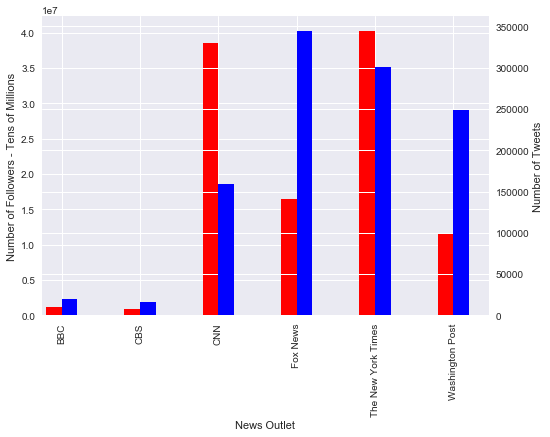

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.2

popular_news['Followers'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
popular_news['Tweets'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Number of Followers - Tens of Millions')
ax2.set_ylabel('Number of Tweets')
ax.set_xlabel('News Outlet')

plt.show()